In [138]:
import networkx as nx
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
import matplotlib

from scipy.misc import imresize

def plot_graph(graph, ax=None, cmap='coolwarm', node_size=300, node_color='.6',labels=False, font_size=24, clusters=None, font_color='k', **kwargs):
    """

    Parameters
    ----------
    graph : object
            A networkX or derived graph object

    ax : objext
         A MatPlotLib axes object

    cmap : str
           A MatPlotLib color map string. Default 'Spectral'

    Returns
    -------
    ax : object
         A MatPlotLib axes object. Either the argument passed in
         or a new object
    """
    if ax is None:
        ax = plt.gca()

    cmap = matplotlib.cm.get_cmap(cmap)

    # Setup edge color based on the health metric
    colors = []
    for s, d, e in graph.edges(data=True):
        if hasattr(e, 'health'):
            colors.append(cmap(e.health)[0])
        else:
            colors.append(cmap(0)[0])

    pos = nx.fruchterman_reingold_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, ax=ax)
    nx.draw_networkx_edges(graph, pos, style='dashed', edge_color=".4",  ax=ax)
    if labels:
        labels = dict((d,d) for d in graph.nodes())
        nx.draw_networkx_labels(graph, pos, labels, font_color=font_color, font_size=font_size,font_weight='bold', ax=ax)
    ax.axis('off')
    return ax

In [139]:
def processify(func):
    '''Decorator to run a function as a process.
    Be sure that every argument and the return value
    is *pickable*.
    The created process is joined, so the code does not
    run in parallel.
    '''

    def process_func(q, *args, **kwargs):
        try:
            ret = func(*args, **kwargs)
        except Exception:
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value, ''.join(traceback.format_tb(tb))
            ret = None
        else:
            error = None

        q.put((ret, error))

    # register original function with different name
    # in sys.modules so it is pickable
    process_func.__name__ = func.__name__ + 'processify_func'
    setattr(sys.modules[__name__], process_func.__name__, process_func)

    @wraps(func)
    def wrapper(*args, **kwargs):
        q = Queue()
        p = Process(target=process_func, args=[q] + list(args), kwargs=kwargs)
        p.start()
        ret, error = q.get()
        p.join()

        if error:
            ex_type, ex_value, tb_str = error
            message = '%s (in subprocess)\n%s' % (ex_value.message, tb_str)
            raise ex_type(message)

        return ret
    return wrapper

In [294]:
from collections import defaultdict, MutableMapping, OrderedDict

from copy import deepcopy

context_schema = {
    "timezone" : "",
    "loc" : [],
    "keywords" : [],
    "state" : ""
}

fact_node_schema = {
    "fb_id" : "",
    "text" : "",
    "entities" : {}
}

class Pipeline(nx.DiGraph):
    """
    """
    def __init__(self, *args, name='generic pipline', **kwargs):
        super(Pipeline, self).__init__(*args, **kwargs)
        self.name = name
        
    def __call__(self, message):
        if not self.nodes():
            raise ValueError('Pipeline {} is an empty network.')
        
        for s,d,data in self.edges(data=True):
            data['data'] = None
        
        self.node['start']['input'] = [message]
        num_nodes = len(self.nodes())
        toponodes = list(nx.topological_sort(self))
        for s in toponodes[:-1]:
            print(s)
            node = self.node[s]
            print(node)
            
            # collect inputs
            if s == 'start':
                inputs = message
            else:
                in_edges = list(self.in_edges(s, data=True))
                if len(in_edges) == 1:
                    inputs = in_edges[0][2]['data']
                else:
                    inputs = [e[2]['data'] for e in in_edges]

            if isinstance(inputs, tuple):
                out = node['func'](*inputs)
            else:
                
        
                out = node['func'](inputs)
            
            out_edges = list(self.out_edges(s, data=True))
            if len(out_edges) == 1:
                out_edges[0][2]['data'] = out
            else:
                for e in out_edges:
                    e[2]['data'] = out

        in_edges = list(self.in_edges(toponodes[-1], data=True))
        if len(in_edges) == 1:
            inputs = in_edges[0][2]['data']
        else:
            inputs = [e[2]['data'] for e in in_edges]
            print(inputs)
        endresult = self.node[toponodes[-1]]['func'](inputs)
        return endresult 
    
    
    def add_node(self, func, name ="", **kwargs):
        if not name:
            name = func.__name__
        super(Pipeline, self).add_node(name, func=func, **kwargs)


In [295]:
from wit import Wit
import os
from multiprocessing import Process, Queue
import traceback
from copy import deepcopy
import louie
import sys
from louie import *

# The different parts of louie
LOC_TOKEN = 'MI3ND56G2NZELC5VWRNCK3MOEVK5ADD5'
FACT_TOKEN = 'WJVG4KBWP7E7NCBKFPODXAD5WJAS2ZHR'
EVENT_TOKEN = '5LJDN3AFRHGYYSIY35JTF2ZTY2H5EFZH'
CONVERSE_TOKEN = '4HL7KZR3G6DK4ZGNLNODRZNZQZCWIC3B'

LOC = Wit(access_token=LOC_TOKEN)
FACT = Wit(access_token=FACT_TOKEN)
EVENT = Wit(access_token=EVENT_TOKEN)
CONVERSE = Wit(access_token=CONVERSE_TOKEN)

bot_indices = {
    'loc' : 0,
    'fact' : 1,
    'event' : 2,
    'converse' : 3
}

numbots = len(bot_indices.keys())

user_context = {
    'user1' : {
        'location' : (35.188,-111.653)
    }
}


def node(func):
    node.queue = Queue()
    def wrapper(*args, **kwargs):
        if args and args[0] is None:
            print('NO DATA')
            return None
        
        try:
            ret = func(*args, **kwargs)
            return ret
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno) 
            print(traceback.print_exc())
    
    wrapper.__name__ = func.__name__
    return wrapper

@node
def start(messagedata):
    data = {}
    fb_id = messagedata['sender']['id']
    context = user_context.get(fb_id)
    data['context'] = context
    data['fb_id'] = fb_id
    data['text'] = messagedata['text']
    data['entities'] = {'intent':[]}
    user_data(data)
    return data

@node
def run_loc(data):
    text = user_data.data['text']
    wit_response = LOC.message(text)
    return 'loc', wit_response['entities']

@node
def run_fact(data):
    text = user_data.data['text']
    wit_response = FACT.message(text)
    return 'fact', wit_response['entities']

@node
def run_event(data):
    text = user_data.data['text']
    wit_response = EVENT.message(text)
    return 'event', wit_response['entities']


@node
def run_converse(data):
    text = user_data.data['text']
    wit_response = CONVERSE.message(text)
    return 'converse', wit_response['entities']

@node
def union(vals):
    if len(edges) == 1:
        return edges['data']
    
    edge_data = [edge['data'] for edge in edges]
    return edge_data
    
@node
def get_confidences_from_entities(bot, entities):
    confidences = np.array([])
    num_entities = len(entities.keys())

    # compute confidences using jank formula
    if 'intent' in entities.keys():
        intent_conf = entities['intent'][0]['confidence'] 
        inverse_intent_conf = 1-intent_conf
    else:
        intent_conf = 0
        inverse_intent_conf = 1


    for entity, arr in entities.items():
        for val in arr:
            if entity == 'intent':
                user_data.data['entities'][entity].append(val['value'])
            else:
                user_data.data['entities'][entity] = val['value']
                confidences = np.append(confidences, val['confidence']*inverse_intent_conf)

    confidence = intent_conf + sum(confidences**2)
    return {'bot' : bot, 'confidence' : confidence}

@node
def user_data(data):
    user_data.data = data

@node
def set_confidences(confidences):
    bot_conf_arr = np.zeros(numbots)
    for conf in confidences:
        bot_conf_arr[bot_indices[conf['bot']]] = conf['confidence']
    return bot_conf_arr

@node
def local_search(confidences):
    key_bot = 'loc'
    confidence = 1
    answer = None
    try:
        NAU_CAMPUS = (35.188,-111.653)

        # get key components of the wit analysis
        params = louie.Params()
        params['noun'] = user_data.data['entities'].get('local_search_query')
        params['location'] = user_data.data.get('location')
        params['sentiemnt'] = user_data.data.get('sentiment')

        if params.get('sentiment') == 'positive':
            sort_by = 'rating'
        else:
            sort_by = 'best_match'

        ll = (0,0)
        if params.get('location') and 'campus' in params.get('location'):
            ll = NAU_CAMPUS
        else:
            ll = user_data.data['context']['location']

        result = yelpclient.search(params.get('noun'), location='Flagstaff, AZ', ll=ll, sort_by=sort_by)
        name = result['businesses'][0]['name']
        location = result['businesses'][0]['location']['address1']

        answer = '{} @ {}'.format(name, location)
    except Exception as e:
        print(e)
        print(traceback.print_exc())
    
    if not answer:
        confidence = 0
    
    confidence = confidences[bot_indices[key_bot]]*confidence
    return answer, confidence

@node
def wolfram_search(confidences):
    key_bot = 'fact'
    confidence = 1
    answer = None
    try:
        query_result = wolfclient.query(user_data.data['entities']['wikipedia_search_query'])

        if 'personq' in user_data.data['entities']['intent']:
            for pod in query_result.pods:
                if pod['@title'] == 'Notable facts':
                    answer = pod['subpod']['plaintext'].split('\n')[0]
        else:
            answer = next(query_result.results).text
    except Exception as e: 
        print(e)
        print(traceback.print_exc())
    
    if not answer:
        confidence = 0
    confidence = confidences[bot_indices[key_bot]]*confidence
    return answer, confidence




@node
def converge_api_answers(results):
    print(results)
    best_answer = sorted(results, key=lambda x:x[1], reverse=True)[0][0]
    
    if not best_answer:
        best_answer = 'no answer'
    return best_answer
    
    

In [1]:
print('TESTS')
print()

test_confidences = [
    {'bot' : 'loc', 'confidence' : .9},
    {'bot' : 'converse', 'confidence' : .8}
]

test_entities0 = {'intent': [{'confidence': 0.55245981772807,
     'value': 'event_search'}],
   'local_search_query': [{'confidence': 0.93791,
     'suggested': True,
     'type': 'value',
     'value': 'tacos'}]}

test_entities1 = {'intent': [{'confidence': 0.99766314336621,
     'value': 'navigation'}],
   'location': [{'confidence': 0.92714,
     'suggested': True,
     'type': 'value',
     'value': 'tacos los altos'}],
   'sentiment': [{'confidence': 0.84524105713291, 'value': 'neutral'}]}

test_entities2 = {'wikipedia_search_query': [{'confidence': 0.93725333333333,
     'suggested': True,
     'type': 'value',
     'value': 'tacos los altos'}]}

context_entities = {
    "local_search_query" : "menudo",
    "location" : "campus",
    "sentiment" : "positive"
}

print('TEST START')
data = start(test_message)
print(data)

print()
print('TESTING BOT CALLS')
test_dict = {'text' : 'navigate to tacos los altos'}
loc = run_loc(test_dict)
event = run_event(test_dict)
fact = run_fact(test_dict)
converse = run_converse(test_dict)

print(event)
print(loc)
print(fact)
print(converse)

print()
print('TESTING CONFIDENCE CONVERGENCE')
locconf = get_confidences_from_entities("event", loc[1])
convconf = get_confidences_from_entities("loc", converse[1])
eventconf = get_confidences_from_entities("converse", event[1])
factconf = get_confidences_from_entities('fact', fact[1])

print(locconf)  
print(convconf) 
print(eventconf)
print(factconf)

print()
print('TESTING CONFIDENCE CONVERGENCE')
print(bot_indices)
bot_conf_array = set_confidences([locconf, convconf, factconf,eventconf])
print(bot_conf_array)

print()
print('TESTING API CALLS')
print(user_data.data)
loc = local_search(bot_conf_array)
wolf = wolfram_search(bot_conf_array)

print(loc)
print(wolf)

TESTS

TEST START


NameError: name 'start' is not defined

In [296]:
G = Pipeline() 
G.add_node(start)
G.add_node(run_event)
G.add_node(run_converse)
G.add_node(run_fact)
G.add_node(run_loc)
G.add_node(get_confidences_from_entities, name="event_converge")
G.add_node(get_confidences_from_entities, name="converse_converge")
G.add_node(get_confidences_from_entities, name="fact_converge")
G.add_node(get_confidences_from_entities, name="loc_converge")
G.add_node(set_confidences, name='converge_confidences')
G.add_node(local_search)
G.add_node(wolfram_search)
G.add_node(converge_api_answers)

G.add_edge('start', 'run_event')
G.add_edge('start', 'run_loc')
G.add_edge('start', 'run_converse')
G.add_edge('start', 'run_fact')

G.add_edge('run_event', 'event_converge')
G.add_edge('run_loc', 'loc_converge')
G.add_edge('run_converse', 'converse_converge')
G.add_edge('run_fact', 'fact_converge')

G.add_edge('event_converge', 'converge_confidences')
G.add_edge('loc_converge', 'converge_confidences')
G.add_edge('converse_converge', 'converge_confidences')
G.add_edge('fact_converge', 'converge_confidences')

G.add_edge('converge_confidences', 'wolfram_search')
G.add_edge('converge_confidences', 'local_search')

G.add_edge('wolfram_search', 'converge_api_answers')
G.add_edge('local_search', 'converge_api_answers')

G.nodes()

['start',
 'run_event',
 'run_converse',
 'run_fact',
 'run_loc',
 'event_converge',
 'converse_converge',
 'fact_converge',
 'loc_converge',
 'converge_confidences',
 'local_search',
 'wolfram_search',
 'converge_api_answers']

Populating the interactive namespace from numpy and matplotlib


/Users/thatcher/anaconda/envs/louie/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'random', 'choice', 'shuffle', 'triangular', 'sort', 'uniform', 'interactive', 'seed', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


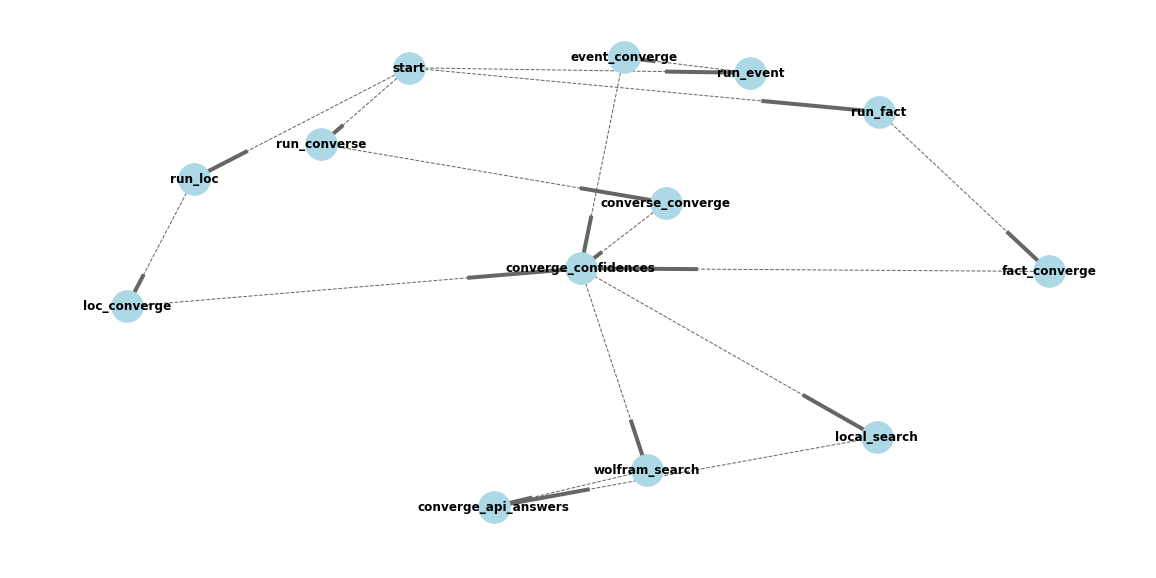

In [297]:
%pylab inline
figsize(20,10)
plot_graph(G, labels=True, node_color='lightblue', node_size=1000, font_size=12, font_color='k')

In [309]:
test_message = {
    'sender' : {'id' : 'user1'},
    'text' : 'Who has the best food'
}

results = G(test_message)

start
{'func': <function node.<locals>.wrapper at 0x127ab9d08>, 'input': [{'sender': {'id': 'user1'}, 'text': 'Who has the best food'}]}
run_event
{'func': <function node.<locals>.wrapper at 0x128904158>}
event_converge
{'func': <function node.<locals>.wrapper at 0x1286209d8>}
run_loc
{'func': <function node.<locals>.wrapper at 0x11ff49ea0>}
loc_converge
{'func': <function node.<locals>.wrapper at 0x1286209d8>}
run_converse
{'func': <function node.<locals>.wrapper at 0x128601ea0>}
converse_converge
{'func': <function node.<locals>.wrapper at 0x1286209d8>}
run_fact
{'func': <function node.<locals>.wrapper at 0x128601620>}
fact_converge
{'func': <function node.<locals>.wrapper at 0x1286209d8>}
converge_confidences
{'func': <function node.<locals>.wrapper at 0x128620d90>}
wolfram_search
{'func': <function node.<locals>.wrapper at 0x128620840>}
results
None
local_search
{'func': <function node.<locals>.wrapper at 0x11ff491e0>}


Traceback (most recent call last):
  File "/Users/thatcher/anaconda/envs/louie/lib/python3.6/site-packages/wolframalpha/__init__.py", line 88, in __getattr__
    val = self[name] if name in self else self[attr_name]
KeyError: '@results'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-295-96b1195fade0>", line 190, in wolfram_search
    answer = next(query_result.results).text
  File "/Users/thatcher/anaconda/envs/louie/lib/python3.6/site-packages/wolframalpha/__init__.py", line 90, in __getattr__
    raise AttributeError(name)
AttributeError: results


[(None, 0.0), ("Satchmo's @ 2320 N 4th St", 0.86142529690000003)]
[(None, 0.0), ("Satchmo's @ 2320 N 4th St", 0.86142529690000003)]


In [303]:
results

"Satchmo's @ 2320 N 4th St"

In [308]:
G.edges['run_event','event_converge']

TypeError: 'method' object is not subscriptable